## POOL mAAPL_UST

Modification2 (Add dsw_oracle fallback_window_size=48h)
### Comparison simulation - volatility mitigator disabled/enabled

*VM parameters (custom):* 
- WINDOW_SIZE = 24h
- FALLBACK_WINDOW_SIZE = 48h
- PERIOD_SIZE = 1h
- PRICE_TOLLERANCE_TRESHOLD = 98

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [3]:
EXPERIMENT_ID = 67

X_NAME = 'mAAPL'
Y_NAME = 'UST'

WINDOW_SIZE = 24 * 60 * 60

In [4]:
BASE_DIR = fr'..\..\..\data\real_transactions\experiment_{EXPERIMENT_ID}'

In [5]:
os.listdir(BASE_DIR)

['0', '1', 'config.txt']

In [6]:
def read_simulation(sim_id: int):
    pool_state_before_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_before_transaction_normalized.csv'
    pool_state_after_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_after_transaction_normalized.csv'
    swap_transactions_path = fr'{BASE_DIR}\\{sim_id}\swaps_normalized.csv'
    mint_transactions_path = fr'{BASE_DIR}\\{sim_id}\mints_normalized.csv'
    burn_transactions_path = fr'{BASE_DIR}\\{sim_id}\burns_normalized.csv'
    
    # read swaps
    pool0_df = pd.read_csv(pool_state_before_transactions_path)
    pool1_df = pd.read_csv(pool_state_after_transactions_path)
    swaps_df = pd.read_csv(swap_transactions_path)
    
    pool0_df.columns = pool0_df.columns.map(lambda x : x + '_before' if x != 'transaction_id' else x)

    swaps_df = pd.merge(swaps_df, pool0_df, left_on='id', right_on='transaction_id')
    swaps_df = pd.merge(swaps_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    swaps_df['transaction_timestamp'] = pd.to_datetime(swaps_df.transaction_timestamp, unit='s')
    swaps_df['block_timestamp'] = pd.to_datetime(swaps_df.block_timestamp, unit='s')
    
    swaps_df.loc[:, 'X_price'] = swaps_df['reserve_Y'] / swaps_df['reserve_X']
    
    # price impact of swap / 100%
    swaps_df.loc[:, 'price_diff'] = (swaps_df['reserve_Y'] / swaps_df['reserve_X'] - swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before']) / (swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before'])
    
    # read mints
    mints_df = pd.read_csv(mint_transactions_path)
    mints_df = pd.merge(mints_df, pool0_df, left_on='id', right_on='transaction_id')
    mints_df = pd.merge(mints_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    # read burns
    burns_df = pd.read_csv(burn_transactions_path)
    burns_df = pd.merge(burns_df, pool0_df, left_on='id', right_on='transaction_id')
    burns_df = pd.merge(burns_df, pool1_df, left_on='transaction_id', right_on='transaction_id') 
    
    return swaps_df, mints_df, burns_df

In [7]:
swaps0_df, mints0_df, burns0_df = read_simulation(0) # without vm
swaps1_df, mints1_df, burns1_df = read_simulation(1) # with vm

In [8]:
swaps0_df.head()

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,1,UST,mAAPL,297.072343,0.0,2.387651,1.188289,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,542,2020-12-03 17:54:47,2020-12-03 17:54:40,0x5c450e4f9908aa58814be20fc50d60b03c3798f99af7...,1,2532.620000,311664.217000,7.893270e+08,0,0,False,2530.232349,311960.101054,7.893315e+08,0,0,False,123.293065,0.001894
1,3,UST,mAAPL,1000.000000,0.0,8.004252,4.000000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,907,2020-12-03 19:26:02,2020-12-03 19:25:57,0x5cc783f79cdab6a966cc9de5d69215dd4199c1f367af...,3,2530.732349,312021.748232,7.896435e+08,0,0,False,2522.728096,313017.748232,7.896587e+08,675029,44,False,124.079067,0.006375
2,5,UST,mAAPL,1000.000000,0.0,7.953707,4.000000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1004,2020-12-03 19:50:17,2020-12-03 19:50:13,0x0d5279feeb6c1536f2f8ee5efda3901352e6697fb84a...,5,2530.788680,314017.943510,7.947131e+08,675029,44,False,2522.834973,315013.943510,7.947282e+08,855564,56,False,124.865061,0.006334
3,6,UST,mAAPL,10000.000000,0.0,76.869789,40.000000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1008,2020-12-03 19:51:17,2020-12-03 19:51:07,0x339975916e81727fbf0060810da871921ca5aecb85aa...,6,2522.834973,315013.943510,7.947282e+08,855564,56,False,2445.965184,324973.943510,7.948750e+08,863056,56,False,132.861230,0.064038
4,7,UST,mAAPL,5000.000000,0.0,36.697936,20.000000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1013,2020-12-03 19:52:32,2020-12-03 19:52:27,0xd2ad1e3793ea315c70b1bd90999caffbe498eb5aefab...,7,2445.965184,324973.943510,7.948750e+08,863056,56,False,2409.267249,329953.943510,7.949472e+08,873021,57,False,136.951990,0.030790


In [9]:
swaps0_df.status.value_counts()

SUCCESS    2117
Name: status, dtype: int64

In [10]:
swaps1_df.status.value_counts()

SUCCESS    2117
Name: status, dtype: int64

In [11]:
ratio_blocked_volatility = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].shape[0]/swaps1_df.shape[0] 

print(f"Blocked by volatility mitigator ratio: {ratio_blocked_volatility}")

Blocked by volatility mitigator ratio: 0.0


In [12]:
swaps1_df.mitigator_check_status.value_counts()

CHECKED                2108
CANT_CONSULT_ORACLE       9
Name: mitigator_check_status, dtype: int64

In [13]:
ratio_twap_not_available = swaps1_df[swaps1_df.mitigator_check_status == 'CANT_CONSULT_ORACLE'].shape[0]/swaps1_df.shape[0] 

print(f"TWAP not available ratio: {ratio_twap_not_available}")

TWAP not available ratio: 0.004251299008030231


In [14]:
# Check if all burns were completed successfully

print("Burns status without volatility mitigation mechanism")
print(burns0_df.status.value_counts())

print("\nBurns status with volatility mitigation mechanism")
print(burns0_df.status.value_counts())

Burns status without volatility mitigation mechanism
SUCCESS    273
Name: status, dtype: int64

Burns status with volatility mitigation mechanism
SUCCESS    273
Name: status, dtype: int64


**0** have been **blocked by the volatility mitigation mechanism**. In only 0.4% of the cases volatility mitigation mechanism didn't check the transaction because of the missing observations in the DSW oracle (77% without modification)

Text(0.5, 1.0, 'Swaps slice_factor/out_amount_diff scatterplot (split by status)')

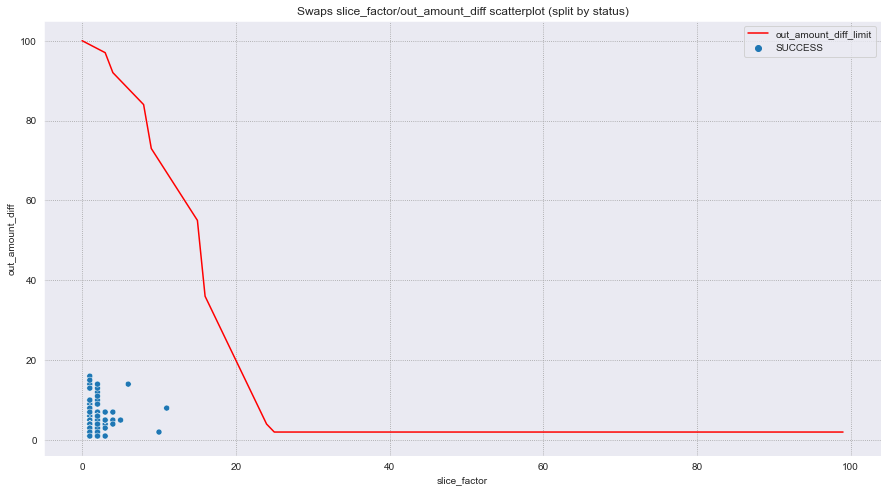

In [15]:
from scipy import stats

fig, ax = plt.subplots(figsize=(15, 8))
    
sns.scatterplot(data=swaps1_df[swaps1_df.mitigator_check_status == 'CHECKED'], x='slice_factor', y='out_amount_diff', hue='status')

slice_factor = np.arange(0, 100)
slice_factor_curve = slice_factor * np.sqrt(slice_factor).astype(int)
slice_factor_curve[slice_factor_curve > 98] = 98
out_amount_diff = (100 - slice_factor_curve)
sns.lineplot(x=slice_factor, y=out_amount_diff, color='red', label='out_amount_diff_limit')
ax.set_title('Swaps slice_factor/out_amount_diff scatterplot (split by status)')

The out_amount_diff_limit border is not smooth, because the slice_factor_curve is computed according to the formula slice_factor * sqrt(slice_factor), where the sqrt(slice_factor) is rounded down in the original contract

**It can be seen that there are more observations than in the initial version, as the volatility mitigation checked much more transactions because of the TWAP availability.**

In [157]:
swaps0_df

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,1,UST,mAAPL,297.072343,0.0,2.387651,1.188289,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,542,2020-12-03 17:54:47,2020-12-03 17:54:40,0x5c450e4f9908aa58814be20fc50d60b03c3798f99af7...,1,2532.620000,3.116642e+05,7.893270e+08,0,0,False,2530.232349,3.119601e+05,7.893315e+08,0,0,False,123.293065,0.001894
1,3,UST,mAAPL,1000.000000,0.0,8.004252,4.000000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,907,2020-12-03 19:26:02,2020-12-03 19:25:57,0x5cc783f79cdab6a966cc9de5d69215dd4199c1f367af...,3,2530.732349,3.120217e+05,7.896435e+08,0,0,False,2522.728096,3.130177e+05,7.896587e+08,675029,44,False,124.079067,0.006375
2,5,UST,mAAPL,1000.000000,0.0,7.953707,4.000000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1004,2020-12-03 19:50:17,2020-12-03 19:50:13,0x0d5279feeb6c1536f2f8ee5efda3901352e6697fb84a...,5,2530.788680,3.140179e+05,7.947131e+08,675029,44,False,2522.834973,3.150139e+05,7.947282e+08,855564,56,False,124.865061,0.006334
3,6,UST,mAAPL,10000.000000,0.0,76.869789,40.000000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1008,2020-12-03 19:51:17,2020-12-03 19:51:07,0x339975916e81727fbf0060810da871921ca5aecb85aa...,6,2522.834973,3.150139e+05,7.947282e+08,855564,56,False,2445.965184,3.249739e+05,7.948750e+08,863056,56,False,132.861230,0.064038
4,7,UST,mAAPL,5000.000000,0.0,36.697936,20.000000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1013,2020-12-03 19:52:32,2020-12-03 19:52:27,0xd2ad1e3793ea315c70b1bd90999caffbe498eb5aefab...,7,2445.965184,3.249739e+05,7.948750e+08,863056,56,False,2409.267249,3.299539e+05,7.949472e+08,873021,57,False,136.951990,0.030790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2112,2897,mAAPL,UST,249.750001,0.0,39857.995848,159.431983,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,2045590,2021-11-23 18:56:47,2021-11-23 18:56:37,0x7d519aeb1052866c81c15ddcc0eb3e8bdeda5b4a7579...,2897,45387.157549,7.356432e+06,3.338875e+11,4245059489,222963,False,45636.907550,7.316414e+06,3.338985e+11,4245185913,222968,False,160.317923,-0.010883
2113,2900,mAAPL,UST,102.461207,0.0,16227.280368,64.909121,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,2047951,2021-11-24 04:47:02,2021-11-24 04:46:57,0xafce0f19611c4fa06045a8561514dd7179261ccba795...,2900,45931.417585,7.364088e+06,3.382430e+11,4245185913,222968,False,46033.878792,7.347796e+06,3.382476e+11,4250863926,223189,False,159.617138,-0.004433
2114,2901,mAAPL,UST,181.894384,0.0,28631.127130,114.524509,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,2048410,2021-11-24 06:41:47,2021-11-24 06:41:41,0x0c88da6763d4694544fbc99c2298fb8ec5f424c83d92...,2901,46033.878792,7.347796e+06,3.382476e+11,4250863926,223189,False,46215.773176,7.319050e+06,3.382556e+11,4251962890,223232,False,158.366935,-0.007833
2115,2902,UST,mAAPL,35000.000000,0.0,217.764726,140.000000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,2048411,2021-11-24 06:42:02,2021-11-24 06:41:57,0xde1d9e9b7ffa66010e2e23a548f3321259b16c16d6cf...,2902,46215.773176,7.319050e+06,3.382556e+11,4251962890,223232,False,45998.008451,7.353910e+06,3.382652e+11,4251965265,223232,False,159.874538,0.009520


Text(0, 0.5, 'Count')

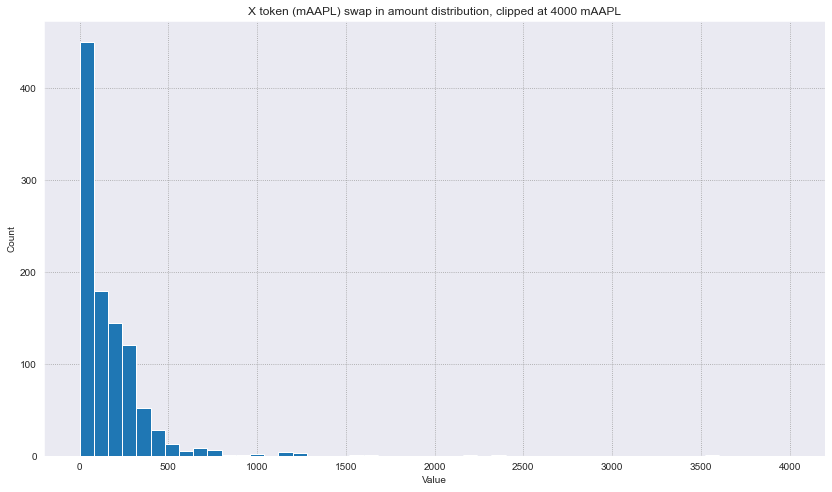

In [158]:
UPPER_LIMIT = 4000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == X_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"X token ({X_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {X_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

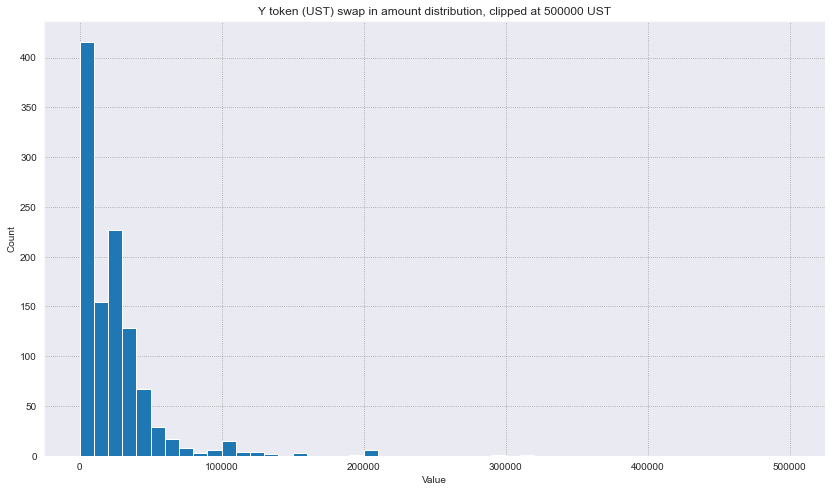

In [159]:
UPPER_LIMIT = 500000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {Y_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

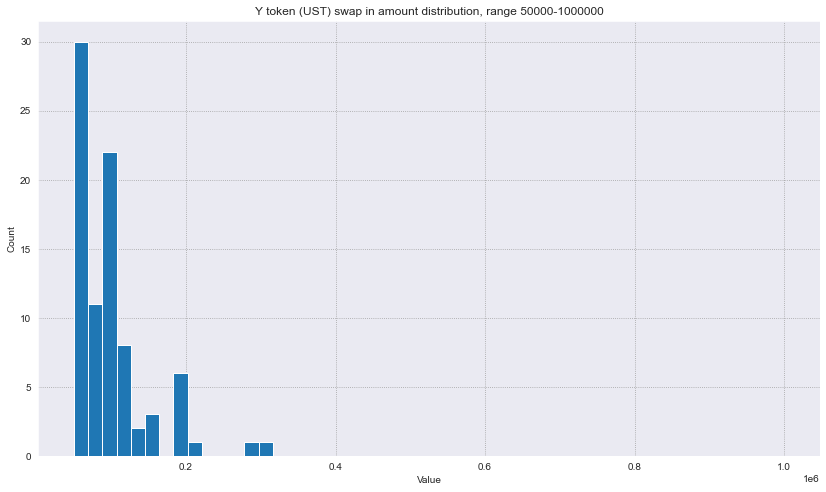

In [160]:
LOWER_LIMIT = 50000
UPPER_LIMIT = 1000000
fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT
amounts = amounts[amounts > LOWER_LIMIT]
ax = amounts.hist(range=(LOWER_LIMIT, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, range {LOWER_LIMIT}-{UPPER_LIMIT}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

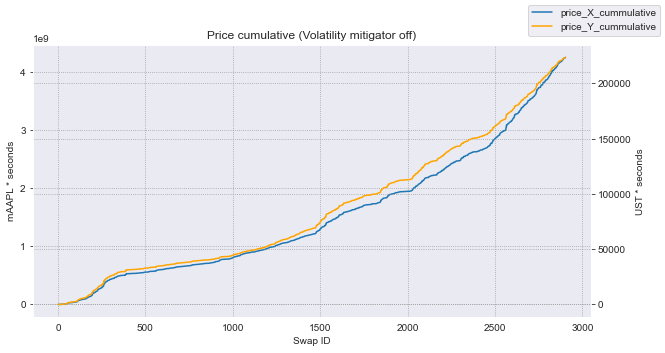

In [161]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.id, swaps0_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps0_df.id, swaps0_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator off)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

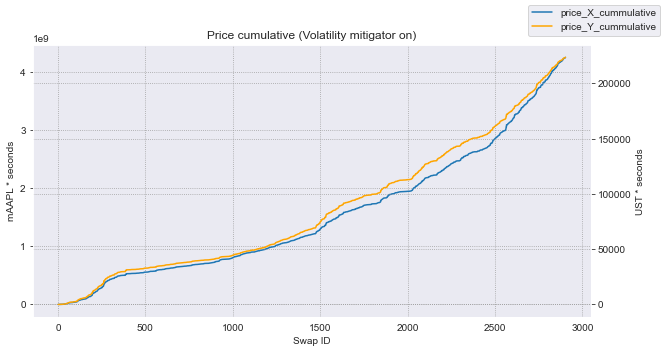

In [162]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.id, swaps1_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator on)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

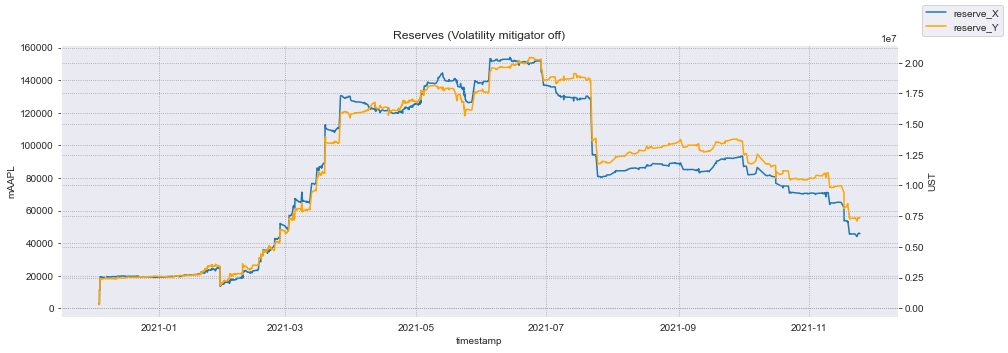

In [163]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label='reserve_X')
ax2.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator off)')

fig.legend()

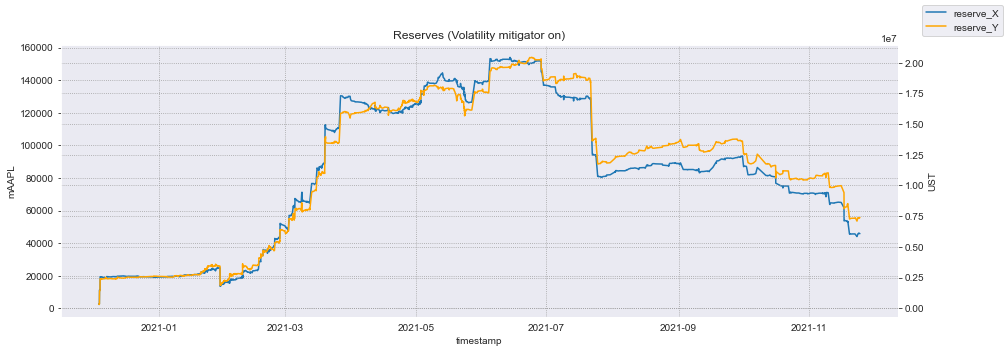

In [164]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()

**The variation of reserves over time is very similar at the first glance with and without the volatility mitigator**

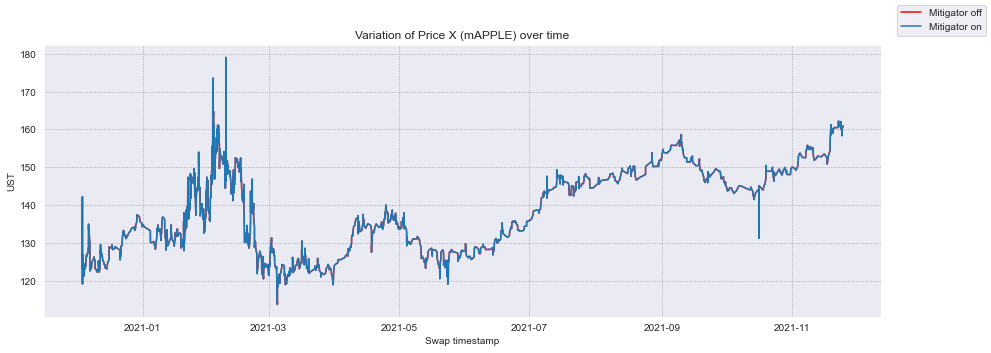

In [121]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
#ax.set_ylim(0, 0.1)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

**The variation of price is the same as in the initial version**

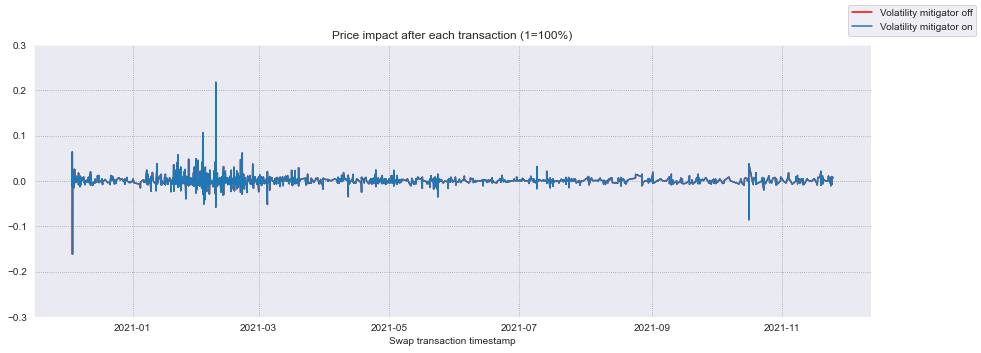

In [165]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()

In [28]:
swaps1_df.iloc[2028:2033][['token_in', 'token_in_amount', 'token_out_amount', 'out_amount_diff', 'slice_factor','reserve_Y_before', 'reserve_Y_before', 'transaction_timestamp', 'X_price']]

,token_in,token_in_amount,token_out_amount,out_amount_diff,slice_factor,reserve_Y_before,reserve_Y_before,transaction_timestamp,X_price
2028,mAAPL,113.991059,16235.929193,NaN,NaN,1.162036e+07,1.162036e+07,2021-10-16 08:18:42,143.666459
2029,mAAPL,3553.094634,483217.805281,5.0,5.0,1.109084e+07,1.109084e+07,2021-10-16 09:32:45,131.305929
2030,UST,200000.000000,1480.292948,6.0,2.0,1.060569e+07,1.060569e+07,2021-10-16 09:32:59,136.269587
2031,UST,150000.000000,1074.977346,2.0,2.0,1.080489e+07,1.080489e+07,2021-10-16 09:37:13,140.052552
2032,UST,199850.638625,1387.636288,NaN,NaN,1.095429e+07,1.095429e+07,2021-10-16 09:39:32,145.172997


**The price impact after each transaction doesn't exceed 0.25 and is the same as initially**

In [125]:
swaps1_df.iloc[725:750]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
725,966,UST,mAAPL,313490.743725,0.0,1913.341160,1253.962975,CHECKED,2078.476324,8.0,11.0,33.0,SUCCESS,387653,2021-02-08 22:52:32,2021-02-08 22:52:22,0x7e262e31704c6c8b638fe545594ddfd7acd95ffbf2b0...,966,20457.340891,3.007952e+06,6.153470e+10,780816423,43351,True,18543.999731,3.320189e+06,6.156958e+10,780820834,43351,True,179.043837,0.217693
726,968,mAAPL,UST,251.381561,0.0,44042.391614,176.169566,CHECKED,37927.774708,14.0,2.0,2.0,SUCCESS,387655,2021-02-08 22:53:02,2021-02-08 22:52:53,0x9c25fdc9ad84bcef3527d31503aa90c89aec804f773a...,968,20462.871786,3.665379e+06,7.500418e+10,780820834,43351,True,20714.253347,3.621160e+06,7.500963e+10,780826207,43351,True,174.814903,-0.024053
727,969,mAAPL,UST,61.940243,0.0,10688.156395,42.752626,CHECKED,9346.195307,13.0,1.0,1.0,SUCCESS,387661,2021-02-08 22:54:32,2021-02-08 22:54:18,0x19e9d0ab55b282ade13aa05b1e5409a2131a4f8b6bb6...,969,20714.253347,3.621160e+06,7.500963e+10,780826207,43351,True,20776.193590,3.610429e+06,7.501098e+10,780841941,43352,True,173.777225,-0.005936
728,970,mAAPL,UST,257.410694,0.0,43748.188540,174.992754,CHECKED,38840.832772,11.0,2.0,2.0,SUCCESS,387661,2021-02-08 22:54:32,2021-02-08 22:54:18,0x29d894eb37a6220a854ee2a26d0b68327bef72b34a42...,970,20776.193590,3.610429e+06,7.501098e+10,780841941,43352,True,21033.604284,3.566506e+06,7.501648e+10,780841941,43352,True,169.562289,-0.024255
729,971,mAAPL,UST,641.926100,0.0,104597.692025,418.390768,CHECKED,96862.764578,7.0,4.0,8.0,SUCCESS,387663,2021-02-08 22:55:02,2021-02-08 22:54:58,0xe8e506485374eb3d5324346704e27034f92168c9c0cf...,971,21033.604284,3.566506e+06,7.501648e+10,780841941,43352,True,21675.530384,3.461490e+06,7.502963e+10,780847028,43352,True,159.695747,-0.058188
730,972,mAAPL,UST,327.569478,0.0,51024.939180,204.099757,CHECKED,49428.517278,3.0,2.0,2.0,SUCCESS,387664,2021-02-08 22:55:17,2021-02-08 22:55:10,0xc506a51a6f701ff5860f81255471b67138510158b8fc...,972,21675.530384,3.461490e+06,7.502963e+10,780847028,43352,True,22003.099862,3.410261e+06,7.503631e+10,780849423,43352,True,154.990024,-0.029467
731,973,mAAPL,UST,336.190574,0.0,50816.450950,203.265804,CHECKED,50729.774967,NaN,NaN,NaN,SUCCESS,387667,2021-02-08 22:56:02,2021-02-08 22:55:57,0x2954589a88559944ca9ee734993f3ffbc32a863289bc...,973,22003.099862,3.410261e+06,7.503631e+10,780849423,43352,True,22339.290436,3.359241e+06,7.504307e+10,780856398,43352,True,150.373677,-0.029785
732,974,mAAPL,UST,66.659662,0.0,9894.390649,39.577563,CHECKED,10058.659253,1.0,1.0,1.0,SUCCESS,387670,2021-02-08 22:56:47,2021-02-08 22:56:35,0x3c227703596b09e360ad17457b5c13f5d9e13053a831...,974,22339.290436,3.359241e+06,7.504307e+10,780856398,43352,True,22405.950098,3.349307e+06,7.504441e+10,780863164,43353,True,149.482940,-0.005923
733,975,mAAPL,UST,68.924194,0.0,10168.992621,40.675970,CHECKED,10400.269204,2.0,1.0,1.0,SUCCESS,387681,2021-02-08 22:59:32,2021-02-08 22:59:32,0xd6d271f001b476b4e004bce7fb3a06514db9f84be74f...,975,22405.950098,3.349307e+06,7.504441e+10,780863164,43353,True,22474.874292,3.339098e+06,7.504580e+10,780887829,43354,True,148.570247,-0.006106
734,976,mAAPL,UST,103.565029,0.0,15163.639226,60.654557,CHECKED,15627.286044,3.0,1.0,1.0,SUCCESS,387685,2021-02-08 23:00:32,2021-02-08 23:00:21,0x8e8f63e463cda0b38a57ffa91391f987d9cdc9100a36...,976,22474.874292,3.339098e+06,7.504580e+10,780887829,43354,True,22578.439321,3.323873e+06,7.504787e+10,780896743,43354,True,147.214485,-0.009125


In [123]:
swaps1_df[swaps1_df.price_diff > 0.4]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
